In [1]:
#%% libraries
import os
import sys
import glob
import itertools
import textract
import nltk
from nltk.corpus import stopwords
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# run for jupyter notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

#### Wrappers for textract functions 

In [7]:
#%% reader functions
def pdf_to_txt(inpath, outpath):
    text = textract.process(inpath, method='pdftotext')
    
    base = os.path.abspath(inpath)
    wdir, fname = outpath, os.path.split(base)[1]
    writepath = wdir + '/' + fname.split('.')[0] + '.txt'

    with open(writepath, 'wb') as f:
        f.write(text)

def read_pdf(inpath):
    text = textract.process(inpath, method='pdftotext')
    return text

#### utility functions

In [8]:
import math

def convert_size(size_bytes):
   if size_bytes == 0:
       return "0B"
   size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
   i = int(math.floor(math.log(size_bytes, 1024)))
   p = math.pow(1024, i)
   s = round(size_bytes / p, 2)
   return "%s %s" % (s, size_name[i])

## Set working directory, Preliminaries

In [9]:
root = '/media/alal/NEPALINEWS/The Kathmandu Post'
os.chdir(root)

#%% directories
input = root 
output = root + '/raw_txts/'

if not os.path.exists(output):
    os.makedirs(output)

%pwd()

'/media/alal/NEPALINEWS/The Kathmandu Post'

*Construct list of files from all subdirectories, store file sizes in dictionary*

In [10]:
pdfs = []
sizes = {}

for root, dirs, files in os.walk(input):
    for file in files:
        if file.endswith(".pdf") and file[0] != '.':
            ff = os.path.join(root, file)
            pdfs.append(ff)
            size = os.path.getsize(ff) # in bytes
            sizes[file] = size

'1010.07 KB'

'395.38 MB'

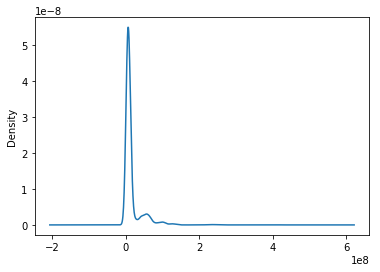

In [11]:
ser = pd.Series(sizes)
ser.plot.density()
convert_size(ser.min())
convert_size(ser.max())

## Bulk convert all pdfs in root - only run once
### Runtime ~= 30 mins

*bulk convert, experimenting with embarrasingly parallel execution*

In [12]:
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()

In [8]:
%%time
results = Parallel(n_jobs=num_cores)(delayed(pdf_to_txt)(p,output) \
                                     for p in pdfs)

CPU times: user 1.94 s, sys: 300 ms, total: 2.24 s
Wall time: 28min 9s


## Construct word frequencies and write dataframes

In [20]:
# pick file, remove punctuation and stopwords
tmp = '/home/alal/tmp'
inp = '/media/alal/NEPALINEWS/The Kathmandu Post/raw_txts'
out = '/media/alal/NEPALINEWS/The Kathmandu Post/word_frequencies/'

if not os.path.exists(out):
    os.makedirs(out)

In [3]:
def write_word_freqs(inputfile,outdir):
    filterout= set(stopwords.words('english')+
               list(string.punctuation)+
               ['\'\'','``','\'s','’',"“","”",
                'the','said','nepal','world','kathmandu'])
    cols = ['word','freq']

    base = os.path.abspath(inputfile)
    wdir, fname = outdir, os.path.split(base)[1]
    writepath = wdir + '/wfreqs_' + fname.split('.')[0] + '.csv'

    f = open(inputfile)
    raw = f.read()
    tokens = [token.lower() for token in nltk.word_tokenize(raw)]
    cleaned = [token for token in tokens if token not in filterout]
    
    fdict = dict(nltk.FreqDist(cleaned))
    df = pd.DataFrame(list(fdict.items()),columns=cols)
    df = df.sort_values('freq',ascending=0)
    
    df.to_csv(writepath,columns=['word','freq'])

In [5]:
files = glob.glob(inp+'/TKP_*.txt')

*parallelize again * 

In [20]:
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()

In [10]:
%%time
results = Parallel(n_jobs=num_cores)(delayed(write_word_freqs)(i,out) \
                                     for i in files)

CPU times: user 976 ms, sys: 96 ms, total: 1.07 s
Wall time: 4min 37s


## Search for keywords

In [195]:
def date_stitcher(ybegin, yend,
                  months = ['{num:02d}'.format(num=x) for x in range(1, 13)], 
                  days= ['{num:02d}'.format(num=x) for x in range(1, 32)] ):
    years = [str(x) for x in range(ybegin, yend)]
    filelist = []
    combinations = list(itertools.product(years, months, days))
    for combination in combinations:
        arguments = "_".join(combination)
        command = 'wfreqs_TKP_' + arguments + '.csv'
        filelist.append(command)
    return filelist


def kw_search(flist, keywords, inpdir,fuzzymatch=False,verbose=False):
    freqcols = ['word', 'freq']
    # initialise dataframe
    tallies = pd.DataFrame(flist, columns=['file']).set_index('file')
    tallies['exists']=np.nan
    for kw in keywords:
        tallies[kw] = np.nan
    # count in all files
    for infile in flist:
        file = inpdir + '/' + infile
        exist_flag = os.path.exists(file)
        if exist_flag:
            tallies.at[infile, 'exists'] = 1
            tkp = pd.read_csv(file, usecols=freqcols, index_col='word')
            for kw in keywords:
                try:
                    # fuzzy match 
                    if fuzzymatch:
                        tkp['word'] = tkp.index
                        tallies.at[infile, kw] = tkp[tkp['word'].str.contains(kw)]['freq'].sum()
                    else:
                    # strict match
                        tallies.at[infile, kw] = pd.to_numeric(tkp.loc[kw])[0]
                    
                except:
                    continue
            if verbose: print(infile, 'loaded and searched')
            del tkp
        else:
            tallies.at[infile, 'exists'] = 0
            if verbose: print(infile, ' does not exist')
            continue
    # subset to nonempty rows
    data = tallies[(tallies['exists']==1)]
    return(data)

def prep_ngram_data(flist,keywords,inp,fuzzymatch=False):
    data = kw_search(flist, keywords, inp, fuzzymatch)
    # this will print a barrage of warnings 
    data.reset_index(level=0, inplace=True)
    data.file = data.file.str[11:21]
    data['date']=pd.to_datetime(data['file'], format='%Y_%m_%d')
    keepvars = ['date']+keywords
    clean = data[keepvars].set_index('date')
    return(clean)

In [196]:
# preliminaries
working = '/media/alal/NEPALINEWS/The Kathmandu Post'
os.chdir(working)
tmp = '/home/alal/tmp'
inp = '/media/alal/NEPALINEWS/The Kathmandu Post/word_frequencies'

# set up list for date ranges
flist = date_stitcher(2007, 2018)
keywords = ['language', 'bhasa', 'maithili','newar', 'tharu', 'tamang']

all data

In [187]:
%%time
clean = prep_ngram_data(flist,keywords,inp,fuzzymatch=True)

CPU times: user 1min 47s, sys: 192 ms, total: 1min 48s
Wall time: 1min 48s


yearly slices

In [207]:
%%time
data2007 = prep_ngram_data(date_stitcher(2007,2008),keywords,inp,fuzzymatch=True)
data2008 = prep_ngram_data(date_stitcher(2008,2009),keywords,inp,fuzzymatch=True)
data2009 = prep_ngram_data(date_stitcher(2009,2010),keywords,inp,fuzzymatch=True)
data2010 = prep_ngram_data(date_stitcher(2010,2011),keywords,inp,fuzzymatch=True)
data2011 = prep_ngram_data(date_stitcher(2011,2012),keywords,inp,fuzzymatch=True)
data2012 = prep_ngram_data(date_stitcher(2012,2013),keywords,inp,fuzzymatch=True)
data2013 = prep_ngram_data(date_stitcher(2013,2014),keywords,inp,fuzzymatch=True)
data2014 = prep_ngram_data(date_stitcher(2014,2015),keywords,inp,fuzzymatch=True)
data2015 = prep_ngram_data(date_stitcher(2015,2016),keywords,inp,fuzzymatch=True)
data2016 = prep_ngram_data(date_stitcher(2016,2017),keywords,inp,fuzzymatch=True)
data2017 = prep_ngram_data(date_stitcher(2017,2018),keywords,inp,fuzzymatch=True)

CPU times: user 1min 48s, sys: 172 ms, total: 1min 48s
Wall time: 1min 48s


## Plots

### year-month averages

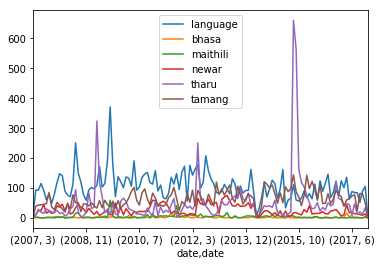

In [206]:
clean.groupby([clean.index.year,clean.index.month]).sum().plot()

### year averages

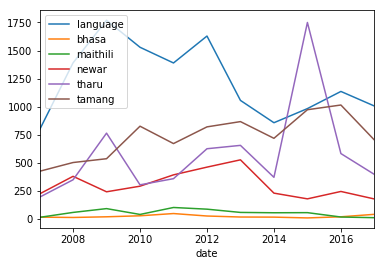

In [202]:
clean.groupby([clean.index.year]).sum().plot()

Text(0.5,1,'word trends - 2007')

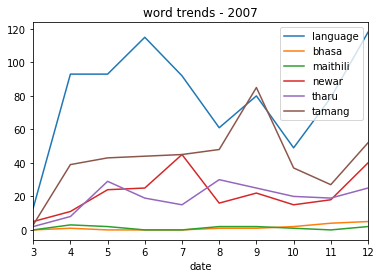

In [208]:
data2007.groupby([data2007.index.month]).sum().plot().set_title('word trends - 2007')

Text(0.5,1,'word trends - 2008')

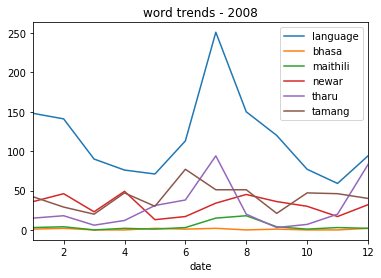

In [209]:
data2008.groupby([data2008.index.month]).sum().plot().set_title('word trends - 2008')

Text(0.5,1,'word trends - 2009')

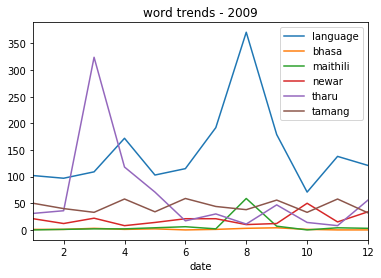

In [210]:
data2009.groupby([data2009.index.month]).sum().plot().set_title('word trends - 2009')

Text(0.5,1,'word trends - 2010')

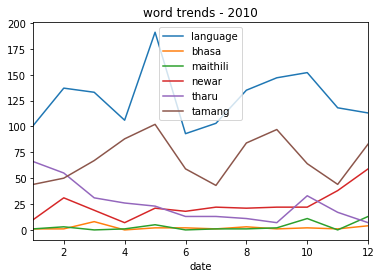

In [211]:
data2010.groupby([data2010.index.month]).sum().plot().set_title('word trends - 2010')

Text(0.5,1,'word trends - 2011')

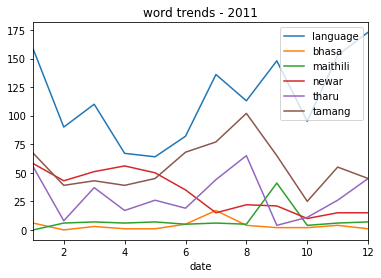

In [212]:
data2011.groupby([data2011.index.month]).sum().plot().set_title('word trends - 2011')

Text(0.5,1,'word trends - 2012')

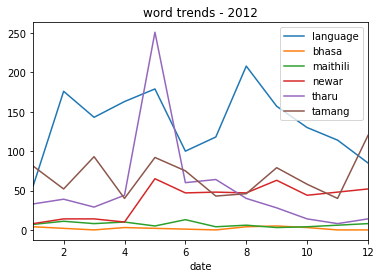

In [213]:
data2012.groupby([data2012.index.month]).sum().plot().set_title('word trends - 2012')

Text(0.5,1,'word trends - 2013')

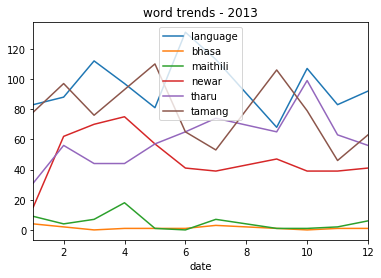

In [214]:
data2013.groupby([data2013.index.month]).sum().plot().set_title('word trends - 2013')

Text(0.5,1,'word trends - 2014')

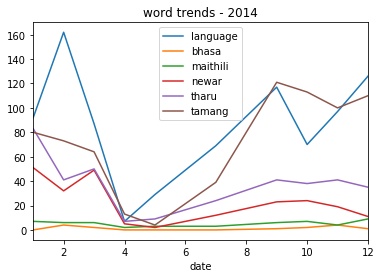

In [215]:
data2014.groupby([data2014.index.month]).sum().plot().set_title('word trends - 2014')

Text(0.5,1,'word trends - 2015')

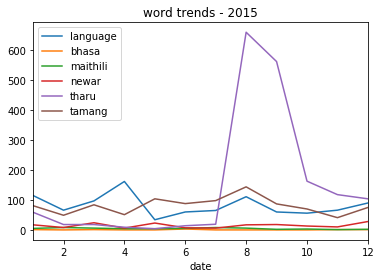

In [216]:
data2015.groupby([data2015.index.month]).sum().plot().set_title('word trends - 2015')

Text(0.5,1,'word trends - 2016')

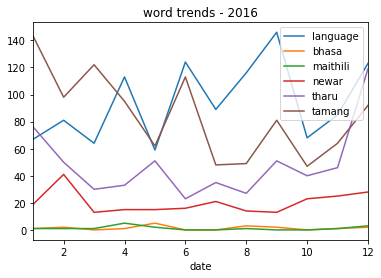

In [217]:
data2016.groupby([data2016.index.month]).sum().plot().set_title('word trends - 2016')

Text(0.5,1,'word trends - 2017')

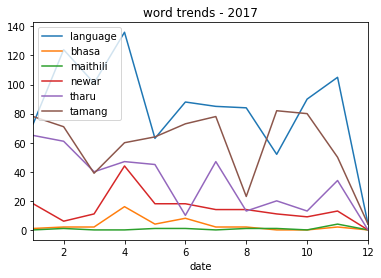

In [218]:
data2017.groupby([data2017.index.month]).sum().plot().set_title('word trends - 2017')